### Loading Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
palette = sns.color_palette("bright", 10)
sns.set(rc={'figure.figsize':(12,8)})

from sklearn.externals import joblib

import cv2
from tensorflow import GradientTape, reduce_mean

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Downloading & Processing CIFAR10 Data

In [ ]:
#downloading cifar10 data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (50000, 32, 32, 3) (50000, 1)
Test data shape:  (10000, 32, 32, 3) (10000, 1)


In [ ]:
#normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

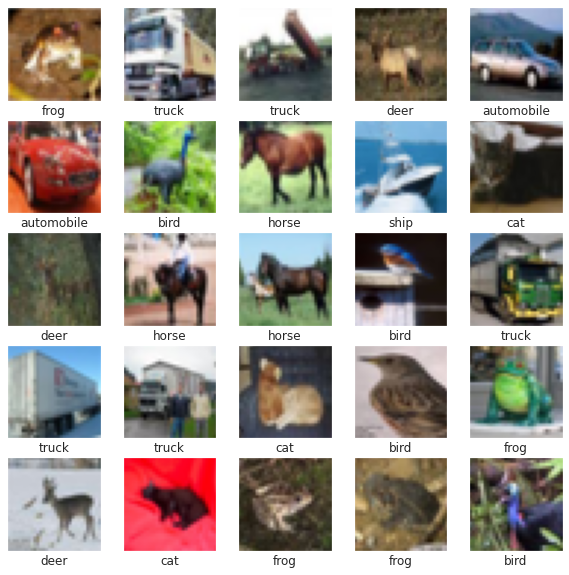

In [ ]:
#displaying sample images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [ ]:
#one hot encoding
y_train_cat = to_categorical(y_train,10)
y_test_cat = to_categorical(y_test,10)

### Training an Image Classification Model - CNN

In [ ]:
#callbacks
earlystop = EarlyStopping(patience = 10, monitor = 'val_accuracy')
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, 
                                            factor = 0.25, min_lr = 0.00001, restore_best_weights = True)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
model = models.Sequential([
               layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
               layers.BatchNormalization(),
               layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2),
               layers.Dropout(0.5),
    
               layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2),
               layers.Dropout(0.5),
    
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2), 
               layers.Dropout(0.5),
    
               layers.Flatten(),
    
               layers.Dense(256, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),
    
               layers.Dense(192, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),
    
               layers.Dense(128, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),

               layers.Dense(10, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 96)        5

In [ ]:
#model fitting
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
 
epochs = 75
history = model.fit(X_train, y_train_cat, epochs = epochs, batch_size = 32, validation_split = 0.1, callbacks = callbacks)

Epoch 1/75
1407/1407 [==============================] - 17s 9ms/step - loss: 2.1877 - accuracy: 0.2629 - val_loss: 1.7420 - val_accuracy: 0.3982
Epoch 2/75
1407/1407 [==============================] - 13s 9ms/step - loss: 1.3953 - accuracy: 0.4942 - val_loss: 1.4940 - val_accuracy: 0.4848
Epoch 3/75
1407/1407 [==============================] - 13s 9ms/step - loss: 1.1536 - accuracy: 0.5931 - val_loss: 1.0811 - val_accuracy: 0.6238
Epoch 4/75
1407/1407 [==============================] - 13s 9ms/step - loss: 0.9999 - accuracy: 0.6531 - val_loss: 0.7955 - val_accuracy: 0.7180
Epoch 5/75
1407/1407 [==============================] - 13s 9ms/step - loss: 0.8908 - accuracy: 0.6949 - val_loss: 0.9236 - val_accuracy: 0.6752
Epoch 6/75
1407/1407 [==============================] - 12s 9ms/step - loss: 0.8241 - accuracy: 0.7157 - val_loss: 0.7387 - val_accuracy: 0.7476
Epoch 7/75
1407/1407 [==============================] - 13s 9ms/step - loss: 0.7679 - accuracy: 0.7418 - val_loss: 0.7455 - val_ac

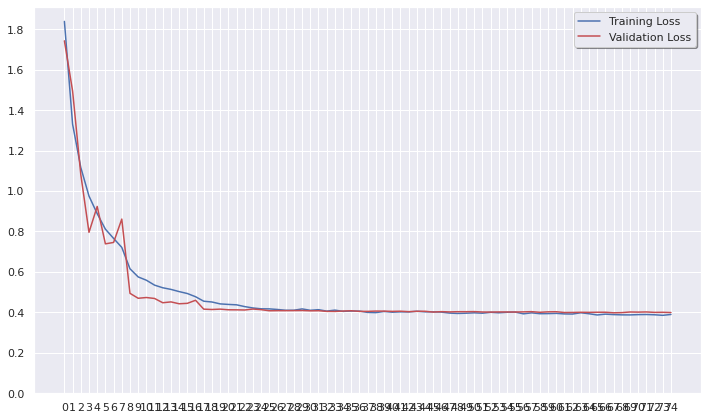

In [ ]:
#loss vs epoch plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(0, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.2))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
#checking model performance on test data
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

313/313 - 3s - loss: 0.4159 - accuracy: 0.8614
Test loss: 0.4159446656703949
Test accuracy: 0.8614000082015991


In [ ]:
#class wise accuracy
y_test_pred = np.argmax(model.predict(X_test), axis = 1)
cm = confusion_matrix(y_test_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.array([[d, c] for d, c in zip(class_names, cm.diagonal())]))

[['airplane' '0.8664047151277013']
 ['automobile' '0.9537512846865365']
 ['bird' '0.8628571428571429']
 ['cat' '0.7491821155943293']
 ['deer' '0.8275538894095595']
 ['dog' '0.7757281553398059']
 ['frog' '0.8360215053763441']
 ['horse' '0.9313621964097148']
 ['ship' '0.9142011834319527']
 ['truck' '0.8993288590604027']]


### Visualizing Output from Last Fully Connected Layer

In [ ]:
#model to extract last fc layer
model_fc = models.Model(inputs = model.input, outputs = model.layers[-4].output)
model_fc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0     

In [ ]:
#extracting feature maps from last fc layer on test data
X_test_fc = model_fc.predict(X_test)

#### T-SNE Plot on Original Data

In [ ]:
#TSNE on test data
X_test_flat = X_test.reshape((-1, 32 * 32 * 3))
tsne = TSNE()
X_embedded = tsne.fit_transform(X_test_flat)

In [ ]:
#saving tsne model on test data
np.save('/content/gdrive/My Drive/DAI_Assignment3/tsne.npy', X_embedded)

In [ ]:
#loading tsne model on test data
X_embedded = np.load('/content/gdrive/My Drive/DAI_Assignment3/tsne.npy') 

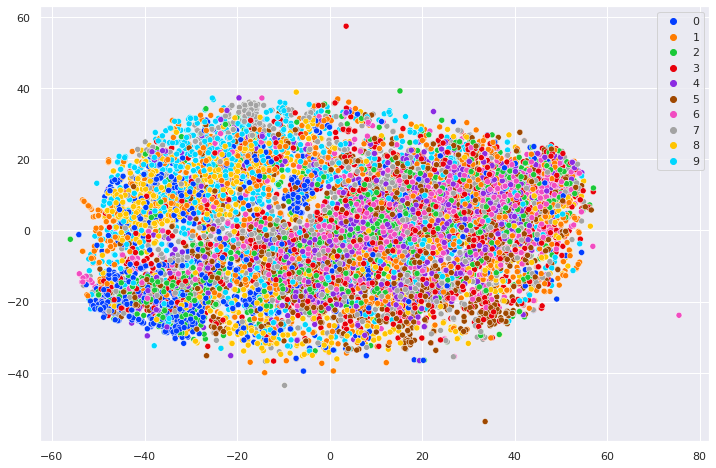

In [ ]:
#plotting TSNE on test data
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = y_test.reshape(y_test.shape[0]), legend = 'full', palette = palette)

#### T-SNE Plot on Output from Last Fully Connected Layer

In [ ]:
#TSNE on last fc layer data
tsne_fc = TSNE()
X_embedded_fc = tsne_fc.fit_transform(X_test_fc)

In [ ]:
#saving tsne model on last fc layer data
np.save('/content/gdrive/My Drive/DAI_Assignment3/tsne_fc.npy', X_embedded_fc)

In [ ]:
#loading tsne model on last fc layer data
X_embedded_fc = np.load('/content/gdrive/My Drive/DAI_Assignment3/tsne_fc.npy')

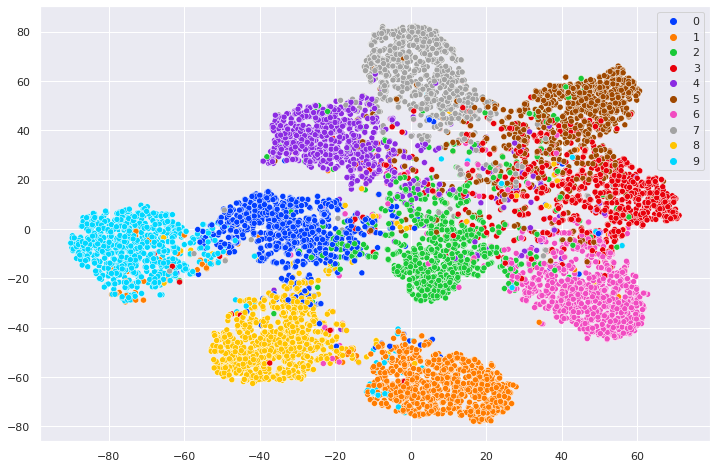

In [ ]:
#plotting TSNE on last fc layer data
sns.scatterplot(X_embedded_fc[:,0], X_embedded_fc[:,1], hue = y_test.reshape(y_test.shape[0]), legend = 'full', palette = palette)

We can clearly see that output from last fully connected layer gives better pattern which is able to group different classes separately

T-SNE tells the data distribution of all classes. When data shows some pattern i.e. each class has some specific attribute which clearly identifies it, its clearly visible in T-SNE. It shows if classes are separable from each other or not. In our example we can see that classes are non-separable as shown in T-SNE on raw data. When we apply subsequent convolution operation on images, some patterns and attributes are learnt which are class specific. When we plot T-SNE on embeddings from last fully connected layer, differences between classes are clearly visible.

### Class Activation Map Analysis

In [ ]:
#model to extract last convolution layer and output
model_cam = models.Model(inputs = model.input, outputs = [model.layers[-17].output, model.output])
model_cam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0     

In [ ]:
#function to plot heatmap for activation_map analysis
def cam_analysis(class_index, img):
    with GradientTape() as tape:
         conv_conv_outs, final_out = model_cam(np.array([img]))
         loss = final_out[:, class_index]
         pred = np.argmax(final_out)

    conv_out = conv_conv_outs[0]  
    gradients = tape.gradient(loss, conv_conv_outs)[0]  
    model_weights = reduce_mean(gradients, axis = (0, 1))   
    activation_map = np.ones(conv_out.shape[0:2], dtype = np.float32) 

    for index, w in enumerate(model_weights):
        activation_map += w * conv_out[:, :, index]

    activation_map = cv2.resize(activation_map.numpy(), (32, 32))
    activation_map = np.maximum(activation_map, 0)
    heatmap = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min()) 
    activation_map = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    mapped_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, activation_map, 1, 0)

    return [pred, mapped_image]

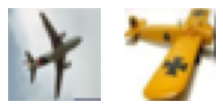

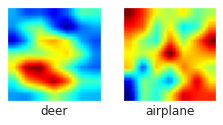

In [ ]:
#Aeroplane Class
np.random.seed(40)
class_index = 0

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


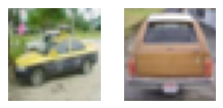

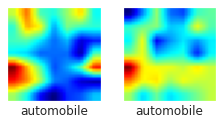

In [ ]:
#Automobile Class
np.random.seed(40)
class_index = 1

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


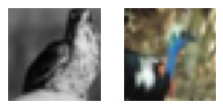

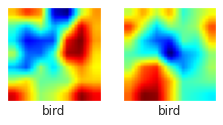

In [ ]:
#Bird Class
np.random.seed(0)
class_index = 2

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


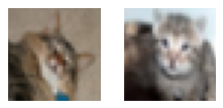

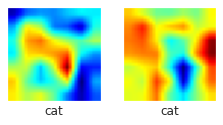

In [ ]:
#Cat Class
np.random.seed(100)
class_index = 3

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


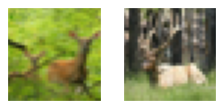

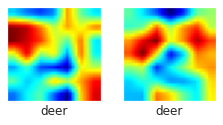

In [ ]:
#Deer Class
np.random.seed(10)
class_index = 4

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


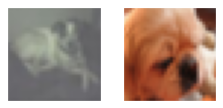

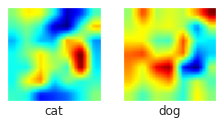

In [ ]:
#Dog Class
np.random.seed(51)
class_index = 5

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


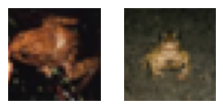

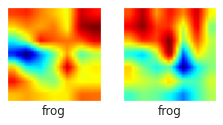

In [ ]:
#Frog Class
np.random.seed(15)
class_index = 6

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


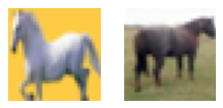

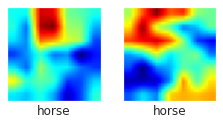

In [ ]:
#Horse Class
np.random.seed(124)
class_index = 7

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


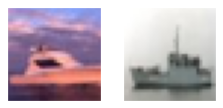

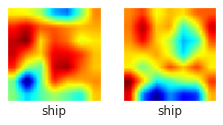

In [ ]:
#Ship Class
np.random.seed(90)
class_index = 8

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


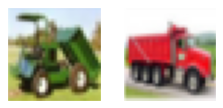

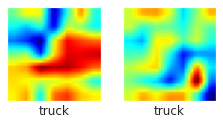

In [ ]:
#Truck Class
np.random.seed(40)
class_index = 9

img_indx = np.random.choice(np.where(y_test == class_index)[0], 2, replace = False)
images = X_test[img_indx]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cam = cam_analysis(class_index = class_index, img = images[i])
    plt.imshow(cam[1], cmap=plt.cm.binary)
    plt.xlabel(class_names[cam[0]])
plt.show()


In above CAM plots, we can clearly see that different regions specific to different classes are activated which leads to their classification.

CAM Analysis tells us the reason behind a model taking any particular decision. It reflects which specific part of image lead to that decision. It is applied on last convolutional layer in the model. In our example, we can clearly see that parts like wheels, wings etc are part behind identification of objects like automobiles, ships, aeroplanes whereas for other objects like dogs, cat, bird parts like mouth, eye are more relevant in the activation map.